# Model creation

In [1]:
# Установка версий программных пакетов
!pip install -r ../requirements.txt -q

В результате проверки результатов обучения моделей разными участниками было выявлено их расхождение при тождественности параметров. Такое несоответствие [происходит](https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras) вследствие использования библиотеками Numpy и TensorFlow случайных чисел в генераторах псевдослучайных значений. Для воспроизодимости результатов обучения в VS Code зафиксируем seed,- начальное значение генератора псевдослучайных чисел.

In [2]:
# Импортируем библиотеки
import mne
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile

# графические библиотеки
from matplotlib import pyplot as plt
%matplotlib widget
import os

# Зафиксируем PYTHONHASHSEED для воспроиизводимости результатов обучения модели
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Логгирование процесса
from comet_ml import Experiment

# библиотеки машинного обучения
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import layers

import random

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


# Скрытие хода обучения модели,который загромождает ноутбук
from IPython.display import clear_output

In [4]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')
from utils.functions import config_reader, f1, callbacks, reset_random_seeds
from utils.data_reader import DataReader
from utils.data_loader import DataLoader
from utils import figures

# Импортируем константы из файла config
config = config_reader() #'../config/data_config.json'

# Импортируем модели
from models.models import SimpleRNN_Model, LSTM_Model

In [ ]:
# experiment = Experiment(
#     api_key = config.api_key, 
#     project_name ='gesture-classification',
#     workspace ='alex1iv',
# );  
# experiment.set_name('model') # имя эксперимента

In [5]:
# константы и глобальные параметры данных
# Все исходные файлы размещены в папке data
PATH = config['PATH']

# Папка для сохранения весов лучшей модели при обучении (исп-ся в ModelCheckpoint в функции callbacks)
PATH_TEMP_MODEL = config['PATH_TEMP_MODEL']

if not os.path.exists(PATH_TEMP_MODEL):
    os.mkdir(PATH_TEMP_MODEL)    

# Папка для сохранения обученных моделей для последующего предсказания
PATH_FOR_MODEL = config['PATH_FOR_MODEL']

if not os.path.exists(PATH_FOR_MODEL):
    os.mkdir(PATH_FOR_MODEL) 

In [6]:
# 1. Установим начальное значение для генератора случайных чисел в Python
random.seed(seed_value)

# 2. Установим начальное значение для генератора случайных чисел в Numpy
np.random.seed(seed_value)

# 3. Установим начальное значение для генератора случайных чисел в tensorflow 
tf.random.set_seed(seed_value)

# 4. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [7]:
# Проверим воспроизводимость результата случайного распределения 
model = keras.Sequential( [ 
layers.Dense(2,name = 'one'),
layers.Dense(3,activation = 'sigmoid', name = 'two'),
layers.Dense(2,name = 'three')])

x = tf.random.uniform((12,12))
print(model(x))

print()

tf.Tensor(
[[ 0.84417915 -0.09455603]
 [ 0.6749006  -0.13408634]
 [ 0.68973166 -0.14211544]
 [ 0.71698654 -0.13607895]
 [ 0.68233585 -0.15881413]
 [ 0.6576998  -0.15178624]
 [ 0.703879   -0.13622592]
 [ 0.7794712  -0.12639348]
 [ 0.8378607  -0.11526634]
 [ 0.7633468  -0.1148871 ]
 [ 0.8343782  -0.09699636]
 [ 0.79229456 -0.12571578]], shape=(12, 2), dtype=float32)



Результат вычислений должен совпадать:
```
tf.Tensor(
[[ 0.84417915 -0.09455603]
 [ 0.6749006  -0.13408634]
 [ 0.68973166 -0.14211544]
 [ 0.71698654 -0.13607895]
 [ 0.68233585 -0.15881413]
 [ 0.6576998  -0.15178624]
 [ 0.703879   -0.13622592]
 [ 0.7794712  -0.12639348]
 [ 0.8378607  -0.11526634]
 [ 0.7633468  -0.1148871 ]
 [ 0.8343782  -0.09699636]
 [ 0.79229456 -0.12571578]], shape=(12, 2), dtype=float32)

```

### Read Data

In [8]:
# Олег - Все в одном цикле, но пока без LSTM
# Словарь для последующей агрегации данных. Изначально прописаны названия файлов в архиве
mounts = config.mounts.toDict()
for i in mounts.keys():
    mounts[int(i)] = mounts.pop(i)
    i = int(i)
    
    # Загружаем данные в словарь с помощью DataLoader
    data_for_nn = DataLoader(i, config)
    mounts[i]['X_train_nn'] = data_for_nn.X_train_nn
    mounts[i]['y_train_nn'] = data_for_nn.y_train_nn
    mounts[i]['X_test_dataset'] = DataReader(
        os.path.join(config.PATH, config.mounts[str(i)].path_X_test_dataset)).data
    
# скрыть вывод
clear_output(wait=False)

### Load and train SimpleRNN

In [9]:
# Олег - Все в одном цикле, но пока без LSTM
# Словарь для последующей агрегации данных. Изначально прописаны названия файлов в архиве
for i in mounts.keys():

    X_train_nn = mounts[i]['X_train_nn']
    y_train_nn = mounts[i]['y_train_nn']

    # Создаём пустой список для записи предсказаний
    mounts[i]['y_trn_nn_ch_list'] = []

    for splt_coef in range(10,100,25): # кол-во разных тренировок зависит от числа разбиений.
        
        val_splt_coef = splt_coef/100

        tf.keras.backend.clear_session()
        reset_random_seeds() # сброс и задание random seed

        model = tf.keras.models.clone_model(model)
        
        model = SimpleRNN_Model(X_train_nn, y_train_nn).build_model()

        model.compile(
            loss="mean_squared_error", 
            metrics=[f1], 
            optimizer='Adam', # по умолчанию learning rate=10e-3
        )


        history = model.fit(
            X_train_nn, 
            y_train_nn, 
            validation_split=val_splt_coef, 
            callbacks=callbacks(num_train=i),  # остальные параметры - смотри в functions.py
            epochs=50,
            verbose=1
        )
        
        #experiment.log_parameter("callbacks", callbacks) # логгируем  callbacks
        
        y_pred_train_nn = model.predict(X_train_nn)  #m.predict(X_train_nn) 
        print(y_pred_train_nn.shape)
        
        #mounts[i]['model'] = model # модели сохранять не нужно
        
        mounts[i]['y_trn_nn_ch_list'].append(y_pred_train_nn)

    # создаём переменную для записи среднего значения предсказаний
    y_pred_train_nn = np.mean(mounts[i]['y_trn_nn_ch_list'], axis=0).argmax(axis=-1)
    
    mounts[i]['y_pred_train_nn'] = tf.keras.utils.to_categorical(y_pred_train_nn)
    y_pred_train_nn = mounts[i]['y_pred_train_nn']

    
    # Сюда можно сразу добавить и обучение LSTM, но можно сделать и в отдельном цикле
    

# скрыть ход обучения модели
clear_output(wait=False)

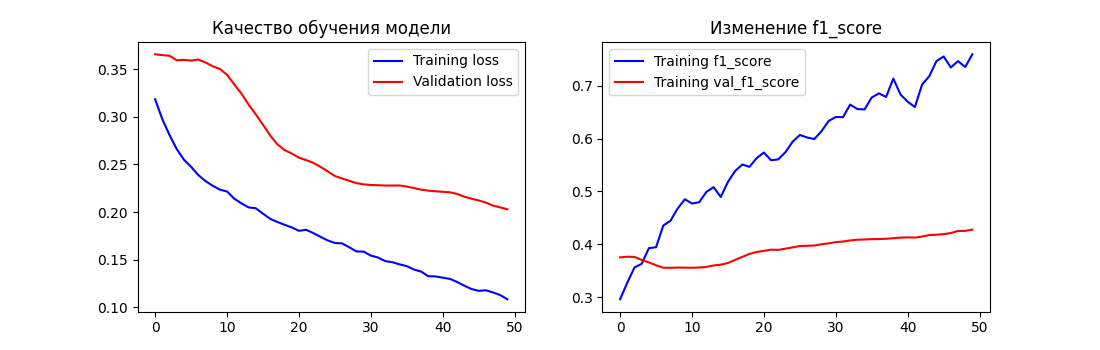

In [10]:
figures.plot_history(history, plot_counter='2-3')
#experiment.log_figure(figure_name='fig_2-3') # логгируем график

### Load and train LSTM

In [11]:
for i in mounts.keys():

    X_train_nn = mounts[i]['X_train_nn']
    y_train_nn = mounts[i]['y_train_nn']
    
    # Обучение модели LSTM на преобразованных данных y_train
    tf.keras.backend.clear_session()
    reset_random_seeds() # сброс и задание random seed
    
    y_pred_train_nn = mounts[i]['y_pred_train_nn']

    model_lstm = LSTM_Model(X_train_nn, y_pred_train_nn).build_model()       

    model_lstm.compile(
        loss="categorical_crossentropy", 
        metrics=[f1], 
        optimizer='Adam', # по умолчанию learning rate=10e-3
    )
    
    m_lstm = tf.keras.models.clone_model(model_lstm)
    
    history2 = model_lstm.fit(
        X_train_nn,
        y_pred_train_nn,
        validation_split=0.2,
        
        #------------------------------------#
        #
        #
        # изменить на 1500
        epochs=1500,      
        verbose=1,
        callbacks=callbacks(lr=0.001, num_train=i) # остальные параметры - смотри в functions.py
    )

    mounts[i]['history2'] = history2
    
    mounts[i]['model_lstm'] = m_lstm

    # сохранение обученной модели в папке по пути PATH_FOR_MODEL
    m_lstm.save(os.path.join(PATH_FOR_MODEL, 'model_lstm_' + str(i) + '.h5'), save_format='h5')
    
    # Расчеты ниже нужны, чтобы посмотреть результат предсказания для модели LSTM на X_train_nn
    y_pred_train_lstm = m_lstm.predict(X_train_nn)
    print(y_pred_train_lstm.shape)
    mounts[i]['y_pred_train_lstm'] = y_pred_train_lstm

# скрыть ход обучения модели
clear_output(wait=False)

input_shape = (107, 50) | output_units = 5
Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 107, 50)]         0         
                                                                 
 batch_normalization (BatchN  (None, 107, 50)          200       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 107, 100)          60400     
                                                                 
 lstm_1 (LSTM)               (None, 107, 100)          80400     
                                                                 
 lstm_2 (LSTM)               (None, 107, 100)          80400     
                                                                 
 lstm_3 (LSTM)               (None, 107, 100)          80400     
             

KeyboardInterrupt: 

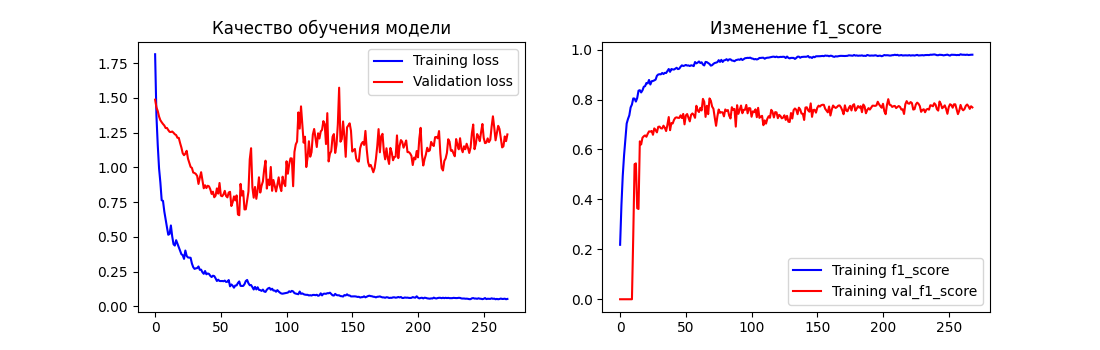

In [15]:
figures.plot_history(history2, plot_counter='2-5')#mounts['history2']
#experiment.log_figure(figure_name='fig_2-5') # логгируем график

Отобразим тренировочные данные: показания датчиков и классы жестов.

Логгируем исходные данные


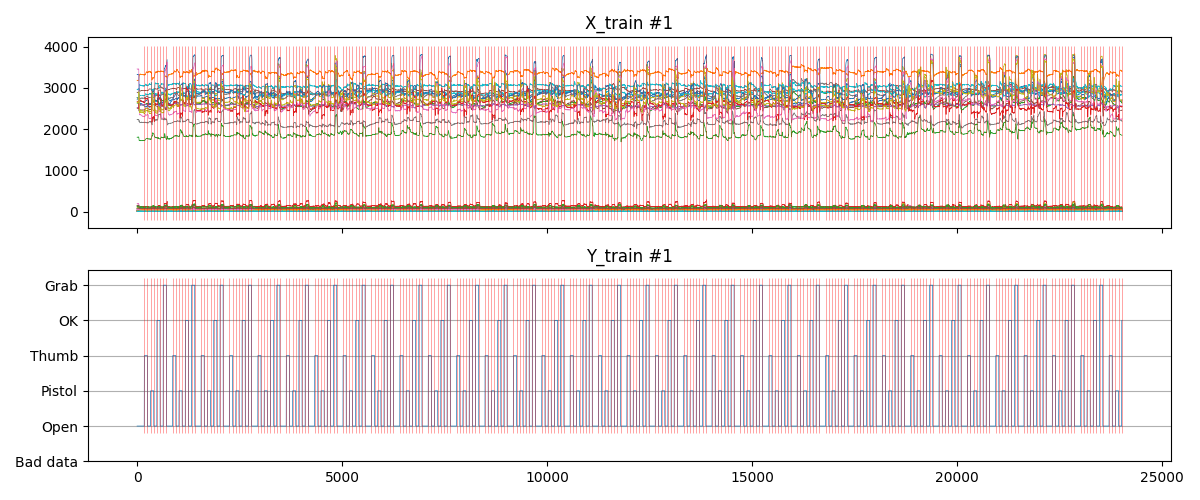

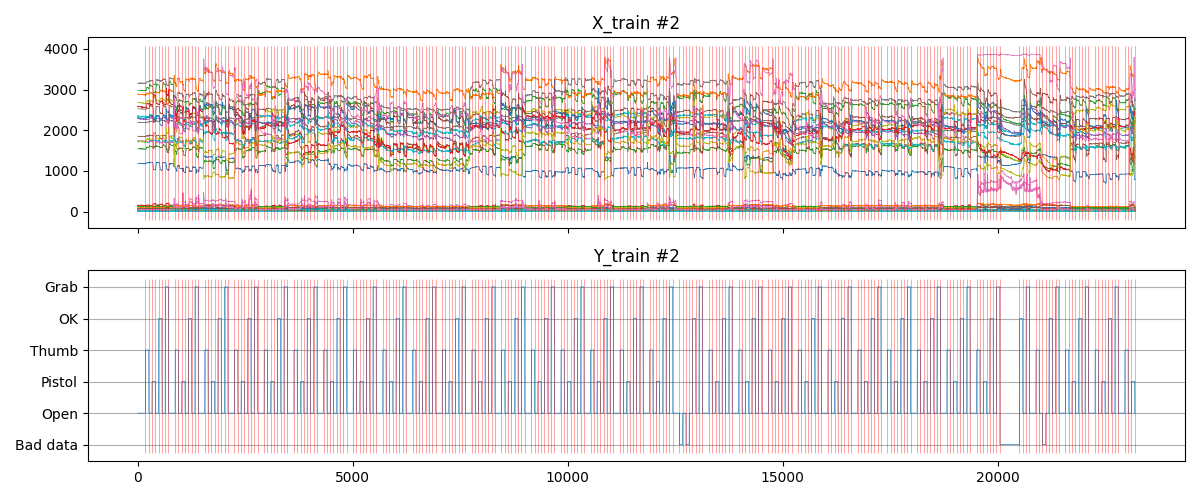

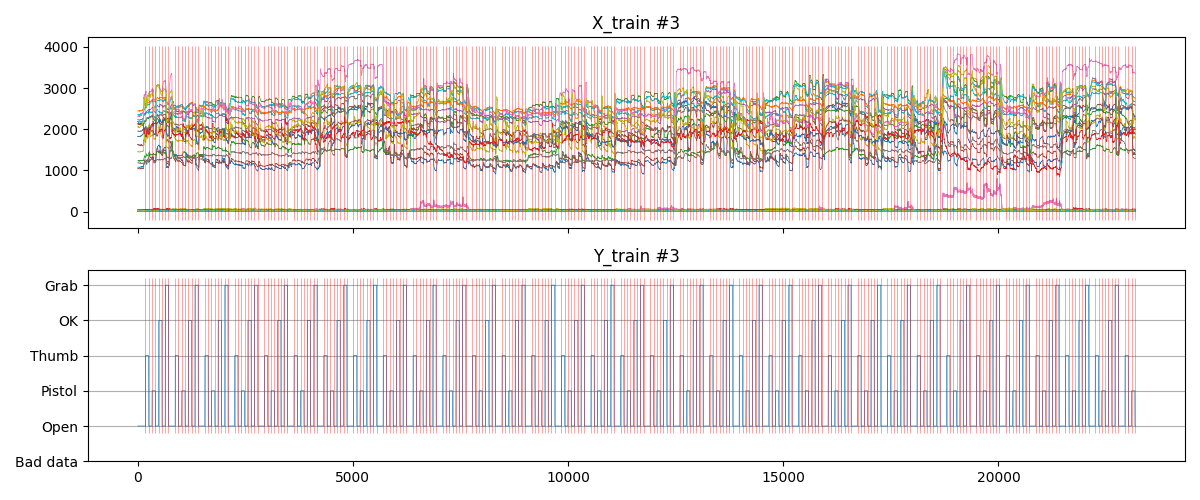

In [11]:
fig = figures.get_display_data(mounts=mounts, plot_counter='2-1')
#print('Логгируем исходные данные')
#experiment.log_image('/gesture_classification/logs_and_figures/fig_2-1.png') # логгируем картинку 
#experiment.end()

### Data preparations for Neural Networks

### Additional functions

### Model architecture (SimpleRNN)

### Model train (SimpleRNN)

In [18]:
# смотрим размерность Pilot_id=1, наблюдения 1 (для примера)
#x_trn_pred_dict[1][0].shape

(276, 107, 5)

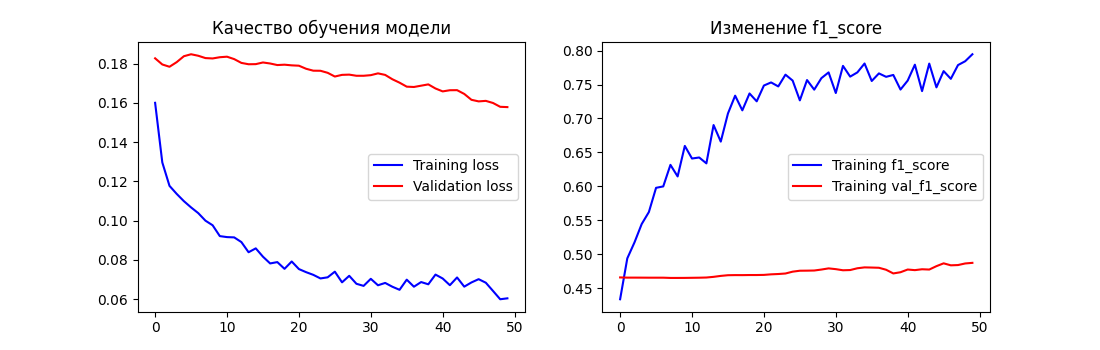

In [19]:
# Визуализируем ход обучения модели #1
#figures.plot_history(history, plot_counter='2-3')
#experiment.log_figure(figure_name='fig_2-3') # логгируем график

### Visualisation SimpleRNN predictions

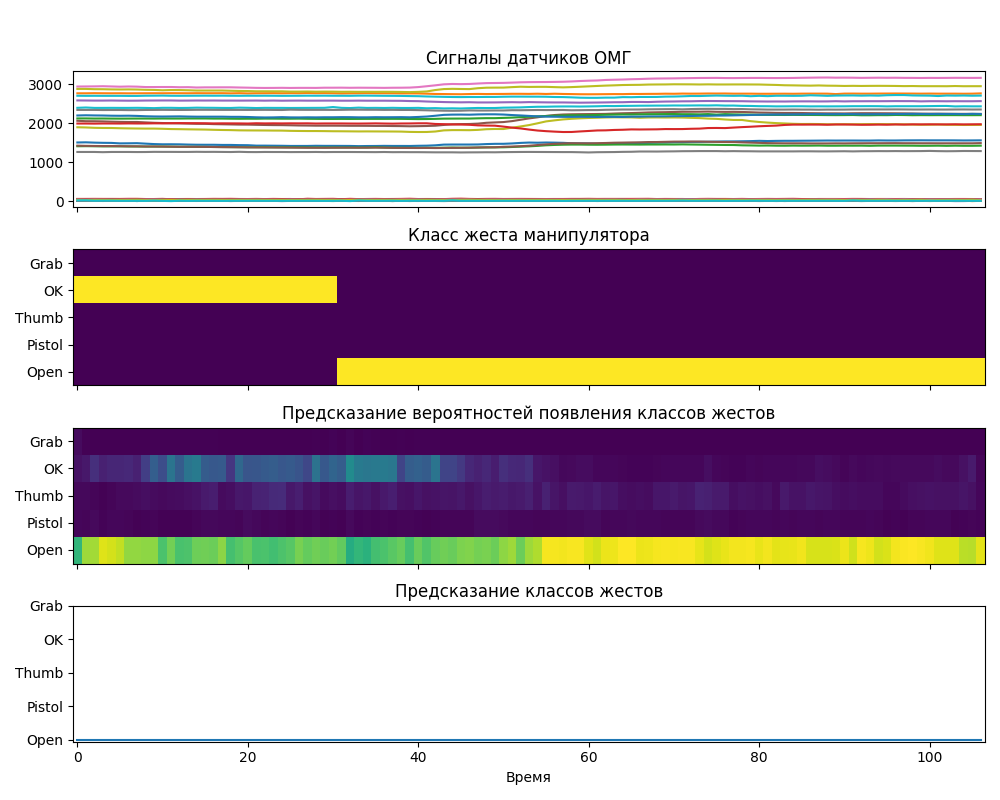

In [20]:
# # Отображение предсказания моделью SimpleRNN
# Pilot_id=3
# y_pred_train_nn = mount['y_pred_train_nn']
# y_pred_train_nn_mean = np.mean(x_trn_pred_dict[Pilot_id], axis=0)

# figures.get_gesture_prediction_plot(
#     Pilot_id=3, 
#     i=5, 
#     mounts=mounts, 
#     y_pred_train_nn_mean=y_pred_train_nn_mean, 
#     plot_counter='2-4'
# )

# #experiment.log_figure(figure_name='fig_2-4') # логгируем график

### Model architecture (LSTM)

### Model train (LSTM)

In [30]:
# Смотрим размерность тренировочных данных перед подачей в модель LSTM для пилота 3
print(f"                        размерность тренировочных данных: {mounts[3]['X_train_nn'].shape}")

# Смотрим размерность целевой переменной перед подачей в модель LSTM для пилота 3
print(f"                          размерность целевой переменной: {mounts[3]['y_train_nn'].shape}") 

# Смотрим размерность усредненной предсказанной целевой переменной перед подачей в модель LSTM для пилота 3
# чтобы сравнить с размерностью целевой переменной (проверяем правильность)
print(f"размерность усредненной предсказанной целевой переменной: {np.mean(x_trn_pred_dict[3], axis=0).shape}") 

                        размерность тренировочных данных: (267, 107, 50)
                          размерность целевой переменной: (267, 107, 5)
размерность усредненной предсказанной целевой переменной: (267, 107, 5)


{'web': 'https://www.comet.com/api/image/download?imageId=a76f8cad406845538a24e444b5c91a92&experimentKey=99bd69c7e6c14d6da851fc1ffcb6cd03',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=a76f8cad406845538a24e444b5c91a92&experimentKey=99bd69c7e6c14d6da851fc1ffcb6cd03',
 'imageId': 'a76f8cad406845538a24e444b5c91a92'}

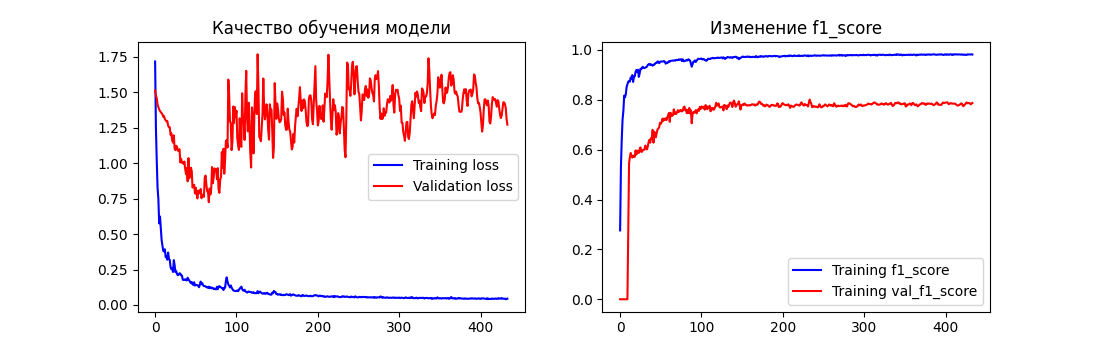

In [ ]:
# Визуализируем ход обучения модели #2
figures.plot_history(history2, plot_counter='2-5') #mounts['history2']
#experiment.log_figure(figure_name='fig_2-5') # логгируем график

### Visualisation LSTM predictions

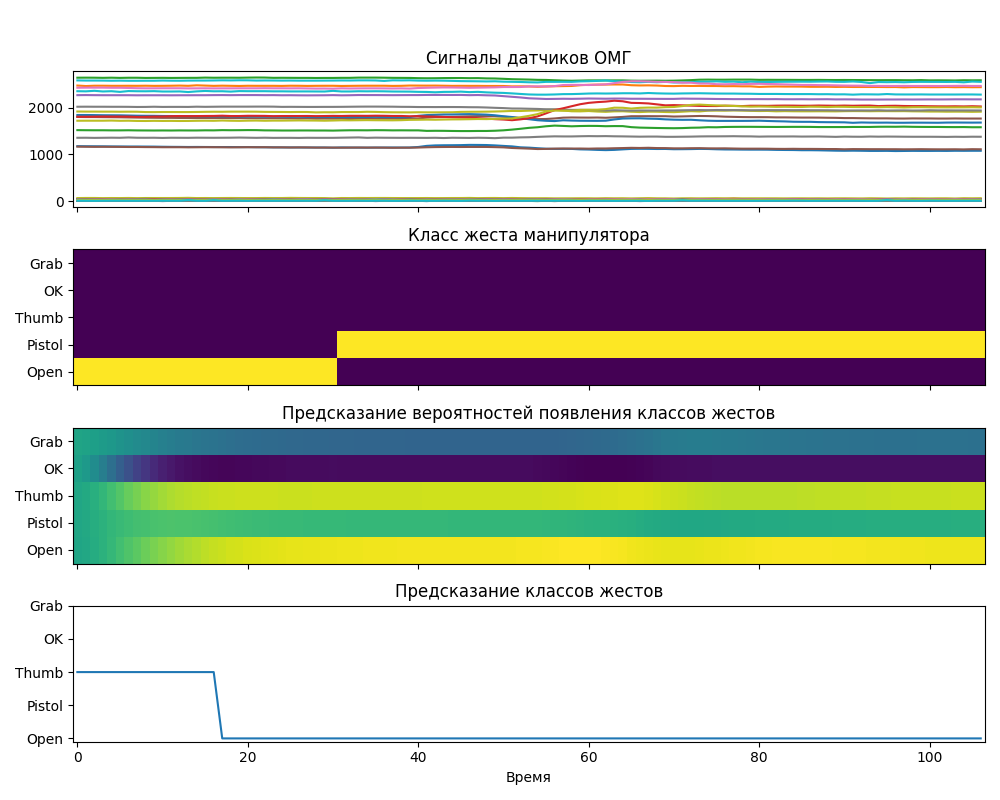

In [18]:
# Визуализируем предскание жеста моделью
Pilot_id=3 # номер пилота

y_pred_train_nn_mean = mounts[Pilot_id]['y_pred_train_lstm']

figures.get_gesture_prediction_plot(
    Pilot_id=3, # номер пилота
    i=18, # номер наблюдения
    y_pred_train_nn_mean=y_pred_train_nn_mean, 
    mounts=mounts, # словарь
    plot_counter='2-6')

#experiment.log_figure(figure_name='fig_2-6') # логгируем график

### Predict test & submit with LSTM model

In [25]:
for mount_name, mount in mounts.items():
    print(mount.keys())

dict_keys(['path_X_train', 'path_y_train', 'path_X_test_dataset', 'X_train_nn', 'y_train_nn', 'y_trn_nn_ch_list', 'y_pred_train_nn', 'history2', 'model_lstm', 'y_pred_train_lstm'])
dict_keys(['path_X_train', 'path_y_train', 'path_X_test_dataset', 'X_train_nn', 'y_train_nn', 'y_trn_nn_ch_list', 'y_pred_train_nn', 'history2', 'model_lstm', 'y_pred_train_lstm'])
dict_keys(['path_X_train', 'path_y_train', 'path_X_test_dataset', 'X_train_nn', 'y_train_nn', 'y_trn_nn_ch_list', 'y_pred_train_nn', 'history2', 'model_lstm', 'y_pred_train_lstm'])


In [31]:
for mount_name, mount in mounts.items():
    
    #Чтение модели LSTM из словаря (после обучения модели LSTM)
    m_lstm = mount['model_lstm']

    X_train_nn = mount['X_train_nn']
    X_test_dataset = mount['X_test_dataset']
    
    y_pred_test_lstm = []
    for i in range(len(X_test_dataset)):
        X_test_i = np.expand_dims(X_test_dataset[i], axis=0).swapaxes(1, 2).astype(np.float64)
        y_pred_test_lstm += [m_lstm.predict(X_test_i, verbose=0)]
        
    y_pred_test_lstm = [arr.argmax(axis=-1) for arr in y_pred_test_lstm]
    
    print(len(y_pred_test_lstm))
    assert len(y_pred_test_lstm) == y_test.query("subject_id == @mount_name")['sample'].nunique()
    
    mount['y_pred_test_lstm'] = y_pred_test_lstm

899
855
861


In [32]:
# Объединяем результаты предсказания в один лист

y_pred_test_res = []
for mount_name, mount in mounts.items():
    y_pred_test_res.extend(mount['y_pred_test_lstm'])
y_pred_test_res = np.concatenate(y_pred_test_res, axis=-1)[0]

# проверка соответствия размерности
assert y_pred_test_res.shape[0] == y_test.shape[0]

In [33]:
# Сохраняем результат предсказания модели в отдельный файл y_test_submit_rnn_LSTM.csv

y_test_submit = y_test[['subject_id-sample-timestep', 'class']]
y_test_submit['class'] = y_pred_test_res
y_test_submit.to_csv('../logs_and_figures/y_test_submit_rnn_LSTM_new.csv', index=False)

y_test_submit

,subject_id-sample-timestep,class
0,1-0-0,2
1,1-0-1,2
2,1-0-2,2
3,1-0-3,2
...,...,...
471606,3-860-177,2
471607,3-860-178,2
471608,3-860-179,2
471609,3-860-180,2


In [ ]:
# Заканчиваем сессию логгирования эксперимента
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/alex1iv/gesture-classification/99bd69c7e6c14d6da851fc1ffcb6cd03
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1 [4833]            : (0.08334998786449432, 0.9976634979248047)
COMET INFO:     batch_loss [4833]          : (0.00656526256352663, 2.3218278884887695)
COMET INFO:     epoch_duration [4833]      : (0.10899999993853271, 9.312999999965541)
COMET INFO:     f1 [4833]                  : (0.27226221561431885, 0.9948285222053528)
COMET INFO:     loss [4833]                : (0.01323469914495945, 1.7169468402862549)
COMET INFO:     lr [4833]                  : (0.00010941899381577969, 0.0010000000474974513)
COMET INFO:     val_f1 [4833]              : (0.0, 0.9366275072097778)
COMET INFO:     val_loss [4833]            : (0.0534

In [ ]:
# отображаем результат обучения
experiment.display()

### Обсуждение результата

Как было показано выше, работа над моделью состояла из двух основных этапов:
- получение на данных X_train разметки y_train, соответствующей моменту совершения жеста;
- обучение итоговой модели на данных X_train и корректированной разметки y_train для последующего предикта на тестовых данных.  

Качество обучения итоговой модели оценивалось по score на Leaderboard, как основному критерию. Предварительно рассматривались результаты предсказания обученной модели для данных X_train.  

За основу итоговой модели (для предикта тестовых данных) была взята нейронная сеть с четырьмя слоями LSTM библиотеки Keras. Для повышения качества обучения рассматривалось: изменение количества слоев LSTM, добавление/исключение слоев BatchNormalization, Dropout и Dense и вариация их параметров и др. Дополнительно использовались встроенные функции callbacks библиотеки Keras, а также варьировалась доля валидационной выборки при обучении модели.

В ноутбуке выше приведена итоговая архитектура модели LSTM, которая стабильно показывала результат, близкий к максимально возможному.  

В ходе выбора архитектуры модели нашей командой и сравнения с результатами score на Leaderboard других команд мы пришли к выводу, что для выбранного метода обучения существует некий порог точности предсказаний на представленных данных, который соответствует примерно score 0.7 на Leaderboard (score при предсказании разными моделями в основном попадал в интервал 0.65 - 0.69, а порог 0.7 так и не был преодолён).  

Сравнение результатов предсказаний наших лучших моделей показало, что они совпадают, в среднем, на 80%. При этом на определенном участке одна модель, к примеру, предсказывала 40 временных единиц, заполненных классом 4, а другая определяла на том же участке одну часть, заполненную классом 1, потом интервал, заполненный классом 4, потом еще интервал - снова класс 1. А на другом участке картина была обратная: вторая модель отработала стабильнее. Таким образом, следуя принципу временных причинно-следственных связей, мы не смогли в режиме реального времени выбрать, какая из тестируемых моделей на конкретном жесте отработала лучше. Такой вывод можно сделать только постфактум. Длина участка с расхождениями могла составить более 10 временных единиц, т.е. постобработка с "запаздыванием" на несколько временных единиц также не добавила бы определенности. Предполагается, что улучшение предсказания можно получить, усреднив предсказания вероятностей классов тремя оптимальными моделями LSTM.  


Основная задача первого этапа заключалась в обучении модели предсказывать классы (жесты) в текущий момент времени по показаниям датчиков и получать момент выполнения жеста (ступеньку на графике y_train) фиксируя момент изменения класса (получение на данных X_train скорректированной разметки y_train).  

Для определения классов нами были протестированы разные модели и архитектуры нейронных сетей библиотеки Keras. Сложная модель SRNN, например, c несколькими слоями SRNN, подстраивала предсказания классов под момент времени, 
соответствующий моменту подачи сигнала манипулятором. Поэтому такая модель давала ошибочные предсказания.

В качестве выборки для обучения других моделей подавались участки X_train двух типов: 
- включающие момент выполнения жеста, 
- участки, где жест оставался неизменным.
 
Однако, модели ошибочно предсказывали отсутствие изменения классов на участках обоих типов.

Поэтому для решения вышеописанной проблемы было решено использовать нейронную сеть SimpleRNN с простой архитектурой и обучать её на различных долях валидационной выборки (применение различных validation_split). Ошибки работы такой модели можно корректировать с помощью усреднения вероятностей предсказаний классов по рассматриваемым validation_split. Это позволит получить корректирующую разметку для последующего обучения более сложной модели (модели со слоями LSTM).

Также проводился анализ влияния корректировки разметки данных на качество предсказания, заключавшийся в следующем: 
- удаление "битых" данных из X_train второго пилота и отдельных выбросов в предсказании y_train; 
- приведение предсказания класса жеста к виду, установленному в протоколе: два класса жеста, разделенных "ступенькой"; 
- подстановка правильных классов в тех эпохах, где SimpleRNN ошиблась в классификации жестов. 

Однако, указанные преобразования не привели к повышению качества предсказаний итоговой модели LSTM. 

Дополнительно нужно отметить, что более 80% ошибок при классификации жестов моделью SimpleRNN заключалось в не распознавании отличия жеста "2" (сгиб большого пальца) от жеста "0" ("open"). Вероятно, показания датчиков этих двух жестов похожи. Поэтому рекомендуется изменить положения оптомиографических датчиков и провести повторный анализ.